In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Third-party
from astropy.utils.console import ProgressBar
import astropy.coordinates as coord
import astropy.units as u
import matplotlib.pyplot as pl
import numpy as np
pl.style.use('ggplot')
%matplotlib inline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import scipy.optimize as so
import emcee

# Custom
import gala.coordinates as gc
import gala.dynamics as gd
from gala.dynamics import mockstream
import rotation_matrix_helper as rmh
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [4]:
# Galactocentric reference frame to use for this project
galactocentric_frame = coord.Galactocentric(z_sun=0.*u.pc,
                                            galcen_distance=8.3*u.kpc)
vcirc = 238.*u.km/u.s
vlsr = [-11.1, 12.24, 7.25]*u.km/u.s

galcen_frame = dict()
galcen_frame['galactocentric_frame'] = galactocentric_frame
galcen_frame['vcirc'] = vcirc
galcen_frame['vlsr'] = vlsr

In [5]:
true_potential = gp.HernquistPotential(m=5E11, c=20., units=galactic)

/anaconda3/lib/python3.6/site-packages/astro_gala-0.4.dev2256-py3.6-macosx-10.7-x86_64.egg/gala/integrate/timespec.py:38: UserWarning: The argument 'nsteps' is deprecated and will be removed in a future version.Use 'n_steps' instead.
  warn("The argument 'nsteps' is deprecated and will be removed in a future version."


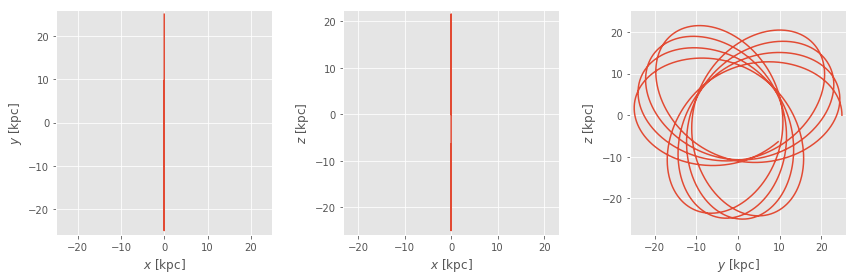

In [6]:
w0 = gd.CartesianPhaseSpacePosition(pos=[0,25.,0]*u.kpc,
                                    vel=[0,0,100]*u.km/u.s)
prog_orbit = true_potential.integrate_orbit(w0, dt=1., nsteps=5500, 
                                            Integrator=gi.DOPRI853Integrator)
fig = prog_orbit.plot()


In [7]:
stream = mockstream.fardal_stream(true_potential, prog_orbit=prog_orbit, 
                                  prog_mass=5E5*u.Msun, release_every=1, Integrator=gi.DOPRI853Integrator)

In [8]:
stream.pos.y

<Quantity [-11.93462281, 17.14284139,-17.81064279,...,   9.42296028,
             9.89975738,  9.48030467] kpc>

Text(0,0.5,'Z [kpc]')

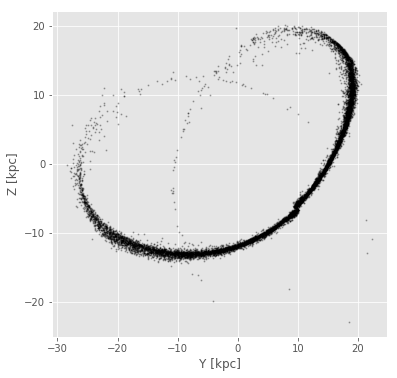

In [9]:
fig,ax = pl.subplots(1,1,figsize=(6,6))
ax.plot(stream.pos.y.value, stream.pos.z.value, 'ko', alpha=0.25, markersize=1)
ax.set_xlabel('Y [kpc]')
ax.set_ylabel('Z [kpc]')

In [10]:
prog_g = prog_orbit.to_coord_frame(coord.Galactic, **galcen_frame)
stream_g = stream.to_coord_frame(coord.Galactic, **galcen_frame)

Text(0,0.5,'b')

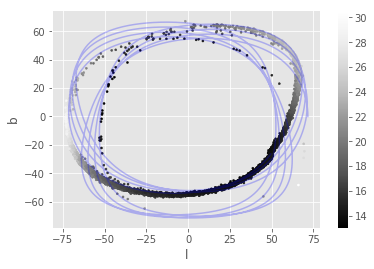

In [11]:
pl.plot(prog_g.l.wrap_at(180*u.deg).degree, prog_g.b.degree, marker=None, alpha=0.25, color='b')
pl.scatter(stream_g.l.wrap_at(180*u.deg).degree, stream_g.b.degree, 
           c=stream_g.distance.value, cmap='Greys_r', s=4)
pl.colorbar()
pl.xlabel('l')
pl.ylabel('b')

In [12]:
idx = np.random.permutation(np.arange(8000, stream_g.l.size, dtype=int)[::2])[:128]

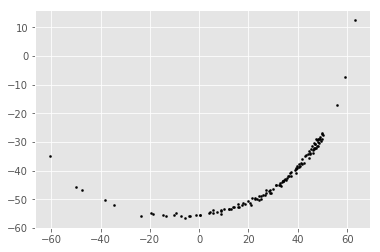

In [13]:
pl.scatter(stream_g[idx].l.wrap_at(180*u.deg).degree, stream_g[idx].b.degree, s=4, c='k')

In [ ]:
np.random.seed(42)
R = rmh.compute_stream_rotation_matrix(stream_g) #, align_lon='max')

> /Users/landerson/python/rotation_matrix_helper.py(75)compute_stream_rotation_matrix()
-> res = minimize(_rotation_opt_func, x0=np.cos(guess), args=(xyz2,), method="powell")
> /Users/landerson/python/rotation_matrix_helper.py(16)_rotation_opt_func()
-> return np.sum(xyz2[2]**2).value


In [16]:
from astropy.coordinates.matrix_utilities import rotation_matrix


In [17]:
R1 = rotation_matrix(17.90243398*u.deg, 'z')
R2 = rotation_matrix(-12.03932305*u.deg, 'y')

In [18]:
xyz2 = (R2*R1).dot(stream_g.represent_as(coord.CartesianRepresentation).xyz)

In [19]:
xyz2

<Quantity [[  7.58841436,  7.73392405,  7.74934726,...,   7.73250344,
              7.7349235 ,  7.72210258],
           [-11.35677429, 16.31283509,-16.94828262,...,   8.96671192,
              9.42042271,  9.02127971],
           [-11.94609079, 13.74660559,-10.18005688,...,  -6.05931029,
             -6.37132198, -6.10136955]] kpc>

In [20]:
    _r = np.sqrt(xyz2[1]**2 + xyz2[2]**2)
    ix = _r.argmin()
    if ix == 0:
        ix += 1
    elif ix == (xyz2[1].size-1):
        ix -= 1


In [23]:
guess = 180*u.degree - np.arctan2(xyz2[2][ix+1]-xyz2[2][ix], xyz2[1][ix+1]-xyz2[1][ix]).to(u.degree)

In [29]:
guess*np.pi/(180*u.deg)

<Quantity 4.644488482472481>

In [27]:
guess.to(u.rad)

<Quantity 4.644488482472481 rad>

In [26]:
np.arccos(np.cos(guess))

<Quantity 1.6386968247071059 rad>

In [ ]:
R = rotation_matrix(np.arccos(th)*u.radian, 'x')